In [146]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import os
from sklearn.cluster import KMeans
from joblib import dump, load
import pandas as pd
from sklearn.neighbors import NearestNeighbors

In [148]:
des_arr = np.array([])
for image in os.listdir('train'):
    path = os.path.join('train',image)
    img = cv.imread(path)
    img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    sift = cv.SIFT_create() # Создание объекта SIFT (Scale-Invariant Feature Transform)
    _, des = sift.detectAndCompute(img,None) # Выделение ключевых точек и их дескрипторов (только дескрипторы)
    
    # Если des_arr пустой, то des_arr становится равным des, иначе дескрипторы объединяются вертикально
    des_arr = des if des_arr.size == 0 else np.vstack((des_arr, des))

In [149]:
# обучение модели кластеризации (K-Means)
#kmeans = KMeans(n_clusters=512, random_state=0).fit(des_arr)

c:\Users\nedor\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [161]:
#dump(kmeans, 'kmeans.joblib') 
kmeans = load('kmeans.joblib')

In [210]:
def vectorize_image(image:np.array,model,n_clusters=512):
    # Используем SIFT для выделения ключевых точек и их дескрипторов
    _, des = sift.detectAndCompute(image, None)

    # Предсказываем классы для дескрипторов
    classes = model.predict(des)

    # Создаем гистограмму на основе классов
    hist, _ = np.histogram(classes, bins=n_clusters)
    
    # Нормализуем гистограмму, избегая деления на ноль
    total_descriptors = len(classes)
    hist = hist / total_descriptors if total_descriptors > 0 else np.zeros_like(hist, dtype=float)
    
    return hist

In [132]:
# import shutil
# import random

# source_folder = r'D:\LabsCV\lab13\Search-Similar-Images\VOCdevkit\VOC2012\JPEGImages'
# destination_folder = r'D:\LabsCV\lab13\Search-Similar-Images\db'

# if not os.path.exists(destination_folder):
#     os.makedirs(destination_folder)

# # Получаем список всех файлов в исходной директории
# all_files = os.listdir(source_folder)

# # Выбираем случайные 1000 файлов
# selected_files = random.sample(all_files, min(1000, len(all_files)))

# # Копируем выбранные файлы в новую директорию
# for file_name in selected_files:
#     source_path = os.path.join(source_folder, file_name)
#     destination_path = os.path.join(destination_folder, file_name)
#     shutil.copyfile(source_path, destination_path)

# print("Создана новая директория с 1000 изображениями:", destination_folder)

Создана новая директория с 1000 изображениями: D:\LabsCV\lab13\Search-Similar-Images\db


In [211]:
db_csv_name = 'db.csv'

In [212]:
ind = 0
for image in os.listdir('db'):
    ind += 1
    path = os.path.join('db',image)
    # Загружаем изображение и конвертируем его в оттенки серого
    img = cv.imread(path)
    img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    # проиндексируем базу ["уникальный индекс", "путь до файла изображения", "вектор кодировки"] 
    df = pd.DataFrame(data={'uid':ind,'filepath':path,'encoding_vector':[vectorize_image(img,kmeans)]})
    # Устанавливаем индекс DataFrame по 'uid'
    df.set_index('uid', inplace=True)
    # Преобразуем массив encoding_vector в строку с разделителями
    df['encoding_vector'] = df['encoding_vector'].apply(lambda x: np.array2string(x, separator=','))
    # Записываем DataFrame в CSV-файл, добавляя данные (append режим)
    df.to_csv(db_csv_name, mode='a', header=not os.path.exists(db_csv_name),sep='\t')

In [213]:
db = pd.read_csv('db.csv',delimiter='\t')
db['encoding_vector'] = db['encoding_vector'].apply(lambda x: eval(x))

In [160]:
# Convert the 'encoding_vector' column to a 2D NumPy array
#data = np.vstack(db['encoding_vector'].values)

#nbrs = NearestNeighbors(n_neighbors=5, metric='cosine').fit(data)

In [214]:
nbrs = load('nbrs.joblib') # NearestNeighbors

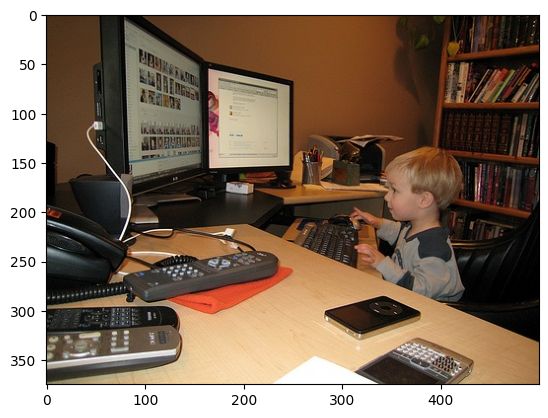

In [215]:
img = cv.imread('db/2007_007203.jpg')
plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))


In [218]:
t_img = vectorize_image(img,kmeans)

_,h = nbrs.kneighbors([t_img],n_neighbors=5)
h

array([[  66, 1074, 1783, 1356,  208]], dtype=int64)

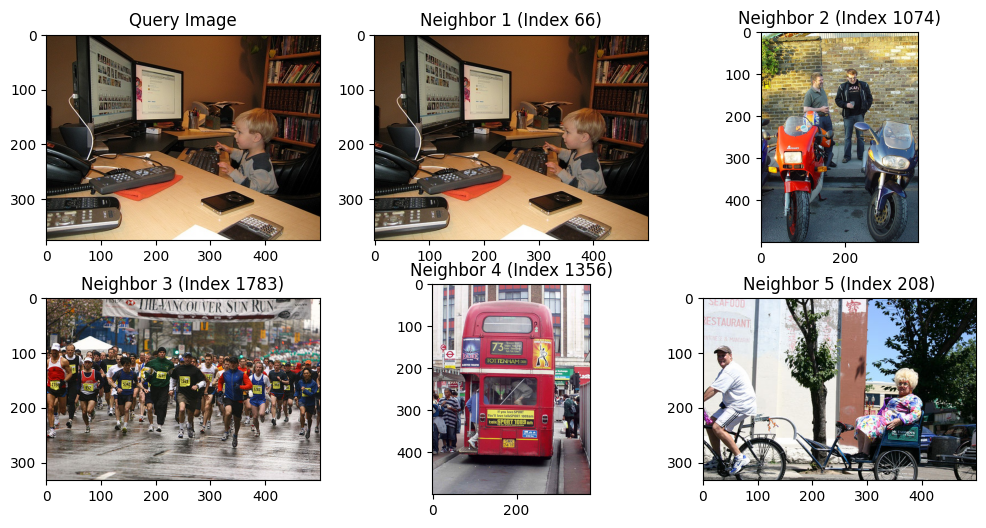

In [219]:
# Plot the query image
plt.figure(figsize=(12, 6))
plt.subplot(2, 3, 1)
query_img = cv.imread(db.loc[h[0][0]]['filepath'])
query_img_rgb = cv.cvtColor(query_img, cv.COLOR_BGR2RGB)
plt.imshow(query_img_rgb)
plt.title(f"Query Image")

# Plot the nearest neighbors
for i, index in enumerate(h[0], start=2):
    plt.subplot(2, 3, i)
    neighbor_img = cv.imread(db.loc[index]['filepath'])
    neighbor_img_rgb = cv.cvtColor(neighbor_img, cv.COLOR_BGR2RGB)
    plt.imshow(neighbor_img_rgb)
    plt.title(f"Neighbor {i - 1} (Index {index})")

plt.show()